# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import kagglehub
import keras
import h5py
import PIL
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import sklearn.decomposition #import PCA
import sklearn.manifold #import TSNE

2025-01-18 08:59:43.164309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737154783.338808   56690 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737154783.389087   56690 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 08:59:43.844850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 32
IMAGE_SHAPE = (150, 150, 3)
CLASS_COUNT = 6
EPOCH = 20

In [30]:
df_check = pd.read_csv('train.csv')

In [32]:
df_check.head()

,image_path,label
0,/home/timohavdk/.cache/kagglehub/datasets/pune...,0
1,/home/timohavdk/.cache/kagglehub/datasets/pune...,5
2,/home/timohavdk/.cache/kagglehub/datasets/pune...,5
3,/home/timohavdk/.cache/kagglehub/datasets/pune...,4
4,/home/timohavdk/.cache/kagglehub/datasets/pune...,3


# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [6]:
PATH_TO_DATA_SET = '/home/timohavdk/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2'

In [8]:
path = kagglehub.dataset_download('puneet6060/intel-image-classification')

print('Path to dataset files:', path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 346M/346M [00:42<00:00, 8.45MB/s]

Extracting files...


Path to dataset files: /home/timohavdk/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [6]:
def make_csv_map(path_to_folder, split_name):
    d = {'image_path': [], 'label': []}
    df = pd.DataFrame(data=d)

    lables = os.listdir(path_to_folder)

    for i in range(0, len(lables)):
        sub_dir = f'{path_to_folder}/{lables[i]}'
        
        files = os.listdir(sub_dir)

        for file in files:
            file_path = f'{sub_dir}/{file}'
            label = i

            new_d = {'image_path': [file_path], 'label': [int(label)]}
            new_df = pd.DataFrame(data=new_d)

            df = pd.concat([df, new_df])

    df['label'] = df['label'].astype('int32')
    
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    df.to_csv(f'{split_name}.csv', index=False)
            
    return lables

In [5]:
paths = [
    (f'{PATH_TO_DATA_SET}/seg_train/seg_train', 'train'),
    (f'{PATH_TO_DATA_SET}/seg_test/seg_test', 'test'),
]

In [8]:
for path, split_name in paths:
    labels = make_csv_map(path, split_name)

    print(labels)

['glacier', 'mountain', 'street', 'sea', 'forest', 'buildings']
['glacier', 'mountain', 'street', 'sea', 'forest', 'buildings']


# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [7]:
RES_NET_SRC = 'microsoft/resnet-50'

In [8]:
processor = transformers.AutoImageProcessor.from_pretrained(RES_NET_SRC)

Load tokenizer to be used with the model

In [9]:
backbone = transformers.TFResNetModel.from_pretrained(RES_NET_SRC)

I0000 00:00:1737154907.293861   56690 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1414 MB memory:  -> device: 0, name: NVIDIA GeForce GT 1030, pci bus id: 0000:09:00.0, compute capability: 6.1
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFResNetModel: ['resnet.encoder.stages.0.layers.0.shortcut.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.0.shortcut.normalization.num_batches_tracked', 'resnet.encoder.stages.1.layers.3.layer.0.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.3.layer.0.normalization.num_batches_tracked', 'resnet.embedder.embedder.normalization.num_batches_tracked', 'resnet.encoder.stages.1.layers.2.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.3.layers.0.layer.1.normalization.num_batches_tracked', 'resnet.encoder.stages.2.layers.4.layer.2.normalization.num_batches_tracked', 'resnet.encoder.stages.0.layers.2.layer.0.normalization.n

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [10]:
files_name = ['train-v2.h5', 'test-v2.h5']
csv_files = ['train.csv', 'test.csv']

In [27]:
def preprocess_and_save_to_hdf5(file_name, csv_file, processor):
    df_dataset = pd.read_csv(csv_file)

    images_count = len(df_dataset)
    
    with h5py.File(file_name, "w") as h5file:
        images_dset = h5file.create_dataset('images', shape=(0, 2048), maxshape=(None, 2048))
        labels_dset = h5file.create_dataset('labels', shape=(0,), maxshape=(None,))
    
        for i in tqdm.tqdm(range(0, images_count)):
            image = PIL.Image.open(df_dataset['image_path'][i])
            image = np.asarray(image)
            
            processed = processor(image, return_tensors="tf")["pixel_values"]
            features = backbone(processed).last_hidden_state
            features = tf.reduce_mean(features, axis=[2, 3]).numpy()
            
            images_dset.resize((images_dset.shape[0] + features.shape[0]), axis=0)
            images_dset[-features.shape[0]:] = features

            labels_dset.resize((labels_dset.shape[0] + features.shape[0]), axis=0)
            labels_dset[-features.shape[0]:] = df_dataset['label'][i]
        
        print(f"Данные сохранены в {file_name}")

In [28]:
for file_name, csv_file in zip(files_name, csv_files):
    preprocess_and_save_to_hdf5(file_name, csv_file, processor)

  0%|          | 0/14034 [00:00<?, ?it/s]

Данные сохранены в train-v2.h5


  0%|          | 0/3000 [00:00<?, ?it/s]

Данные сохранены в test-v2.h5


# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [33]:
def check_hdf5_dataset(filepath):
    dataset = None
    with h5py.File(filepath, "r") as h5file:
        images = h5file["images"][:]
        labels = h5file["labels"][:]

        print(images.shape, labels.shape)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [35]:
check_hdf5_dataset('test-v2.h5')

(3000, 2048) (3000,)


In [12]:
def create_hdf5_dataset(h5_file_path):
    def load_data_from_h5(index):
        with h5py.File(h5_file_path, "r") as h5file:
            features = h5file["images"][index]
            labels = h5file["labels"][index]
        return features, labels
    
    def get_item(index):
        features, labels = tf.py_function(
            func=load_data_from_h5,
            inp=[index],
            Tout=[tf.float32, tf.int32]
        )
        
        features.set_shape((2048))
        labels.set_shape(())
        return features, labels
    
    with h5py.File(h5_file_path, "r") as h5file:
        dataset_size = len(h5file["labels"])

        print(dataset_size)

        indices = tf.data.Dataset.range(dataset_size)
        dataset = indices.map(get_item, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
train_ds = create_hdf5_dataset("train-v2.h5")
validation_ds = train_ds.take(62)
train_ds = train_ds.skip(62)
test_ds = create_hdf5_dataset("test-v2.h5")

14034
3000


# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [14]:
def get_model():
    inputs = keras.layers.Input(shape=(2048,))
    outputs = keras.layers.Dense(CLASS_COUNT, activation="softmax")(inputs)

    model = keras.models.Model(inputs, outputs)

    return model

In [15]:
model = get_model()

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,294 (48.02 KB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 0 (0.00 B)

Compile the model. Choose loss and metrics.

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model

In [26]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [27]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [28]:
def get_callbacks(model_name: str):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        os.path.join(logdir, f'model-{model_name}.keras'),
        save_best_only=True
    )

    return model_checkpoint_callback

In [29]:
checkpoint_callback = get_callbacks('res-net-image-classification')

In [30]:
model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    callbacks=[checkpoint_callback]
)

Epoch 1/20


I0000 00:00:1733739840.524021   60603 service.cc:148] XLA service 0x7f3c0c0060f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733739840.524060   60603 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2024-12-09 20:24:00.586617: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733739840.736261   60603 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1733739841.216655   60603 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/377 ━━━━━━━━━━━━━━━━━━━━ 1:20:00 13s/step - accuracy: 0.1250 - loss: 1.8251

I0000 00:00:1733739841.755522   60603 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


377/377 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - accuracy: 0.7809 - loss: 0.8547 - val_accuracy: 0.9189 - val_loss: 0.2916
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 71s 160ms/step - accuracy: 0.9054 - loss: 0.2790 - val_accuracy: 0.9320 - val_loss: 0.2378
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 71s 160ms/step - accuracy: 0.9183 - loss: 0.2332 - val_accuracy: 0.9299 - val_loss: 0.2194
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 72s 161ms/step - accuracy: 0.9250 - loss: 0.2107 - val_accuracy: 0.9309 - val_loss: 0.2102
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 75s 169ms/step - accuracy: 0.9301 - loss: 0.1956 - val_accuracy: 0.9309 - val_loss: 0.2049
Epoch 6/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.9321 - loss: 0.1843 - val_accuracy: 0.9309 - val_loss: 0.2016
Epoch 7/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 72s 171ms/step - accuracy: 0.9356 - loss: 0.1751 - val_accuracy: 0.9325 - val_loss: 0.1994
Epoch 8/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 72s 169ms/step - accuracy: 0.9388 - loss: 0.1673 - val

In [54]:
model.save('img_classification.keras')

In [18]:
model = keras.models.load_model('img_classification.keras')

# Evaluation

Evalute the model on test data.

In [19]:
model.evaluate(test_ds)

I0000 00:00:1737155062.477588   56932 service.cc:148] XLA service 0x7f42e4004f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737155062.478644   56932 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GT 1030, Compute Capability 6.1
2025-01-18 09:04:22.536123: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737155062.639429   56932 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9114 - loss: 0.2366

I0000 00:00:1737155063.175963   56932 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 0.9294 - loss: 0.1874


[0.18394945561885834, 0.9283333420753479]

Plot confusion matrix.

In [20]:
def get_processed_dataset(file_path):
    images_test = None
    labels_test = None
    
    with h5py.File(file_path, "r") as h5file:
        images_test = h5file["images"][:]
        labels_test = h5file["labels"][:]

        return images_test, labels_test

In [21]:
images_test, labels_test = get_processed_dataset('test-v2.h5')

In [22]:
images_test.shape

(3000, 2048)

In [23]:
predictions = model.predict(images_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


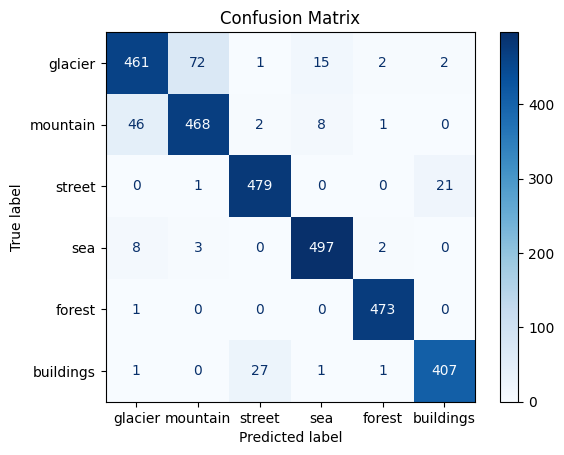

In [36]:
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(labels_test, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['glacier', 'mountain', 'street', 'sea', 'forest', 'buildings'])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

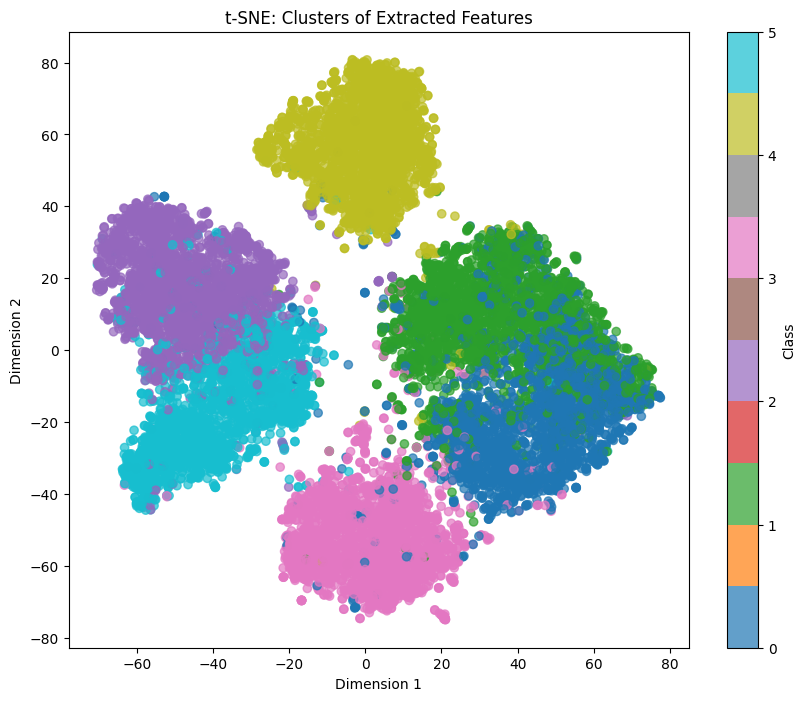

In [25]:
images_train, labels_train = get_processed_dataset('train-v2.h5')

def reduce_dimensionality(features, method="PCA", n_components=2):
    if method == "PCA":
        reducer = sklearn.decomposition.PCA(n_components=n_components)
    elif method == "t-SNE":
        reducer = sklearn.manifold.TSNE(n_components=n_components, perplexity=30, random_state=42)
    
    reduced_features = reducer.fit_transform(features)
    return reduced_features

reduced_features = reduce_dimensionality(images_train, method="t-SNE")

def plot_clusters(features, labels, file_name, title="Feature Clusters"):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Class")
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.savefig(file_name)
    plt.show()
   

plot_clusters(reduced_features, labels_train, 't-sne.png', title="t-SNE: Clusters of Extracted Features")

In [26]:
reduced_features = reduce_dimensionality(images_train, method="PCA")

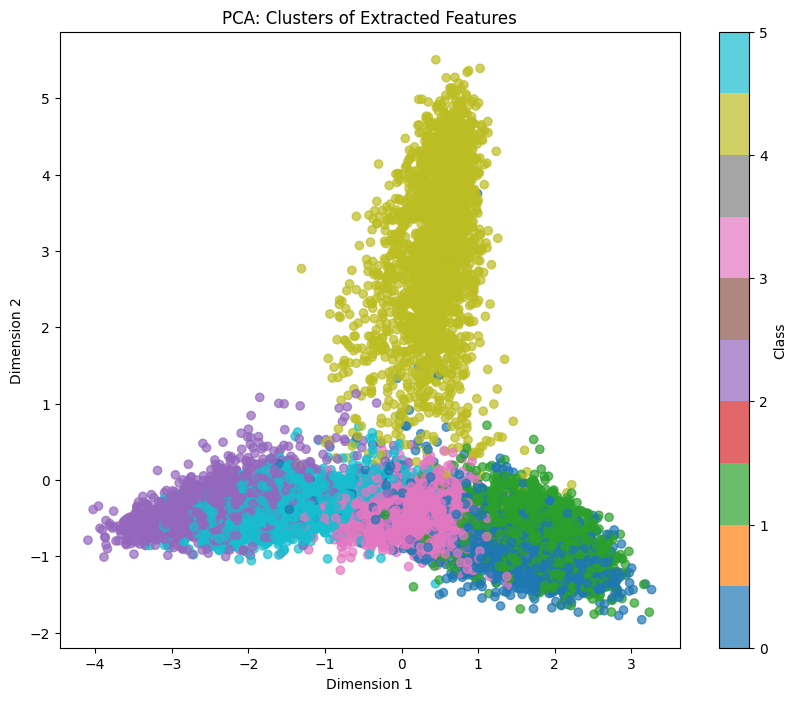

In [27]:
plot_clusters(reduced_features, labels_train, 'pca.png', title="PCA: Clusters of Extracted Features")

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween the same and different classes)

In [28]:
images_test, labels_test = get_processed_dataset('test-v2.h5')

In [29]:
def calculate_similarity(features, labels):
    same_class_similarities = []
    different_class_similarities = []

    for i in tqdm.tqdm(range(len(features))):
        for j in range(i + 1, len(features)):
            sim = sklearn.metrics.pairwise.cosine_similarity([features[i]], [features[j]])[0, 0]
            if labels[i] == labels[j]:
                same_class_similarities.append(sim)
            else:
                different_class_similarities.append(sim)

    return np.mean(same_class_similarities), np.mean(different_class_similarities)

same_mean, different_mean = calculate_similarity(images_test, labels_test)

print(f"Среднее сходство для одного класса: {same_mean:.4f}")
print(f"Среднее сходство для разных классов: {different_mean:.4f}")

print(f"Разница средних: {same_mean - different_mean:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

Среднее сходство для одного класса: 0.5274
Среднее сходство для разных классов: 0.3027
Разница средних: 0.2247
